In [1]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import sqlite3
import matplotlib.pyplot as plt

In [5]:
MAPPING_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/recalibrated-percolator-output/percolator-idx-mapping.csv"

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

#### visualise the region in the raw data estimated by the coordinate estimators

In [10]:
EXPERIMENT_METRICS_FILE_NAME = "/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl"
experiment_metrics_for_library_sequences_df = pd.read_pickle(EXPERIMENT_METRICS_FILE_NAME)

In [11]:
experiment_metrics_for_library_sequences_df.columns

Index(['sequence', 'charge', 'theoretical_mz', 'experiment_scan_mean',
       'experiment_scan_std_dev', 'experiment_scan_peak_width',
       'experiment_rt_mean', 'experiment_rt_std_dev',
       'experiment_rt_peak_width', 'experiment_intensity_mean',
       'experiment_intensity_std_dev', 'number_of_runs_identified', 'q_value',
       'file_idx', 'target_coords', 'decoy_coords', 'target_metrics',
       'attributes', 'decoy_metrics'],
      dtype='object')

In [32]:
SEQUENCE_LIBRARY_FILE_NAME = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/sequence-library/sequence-library.pkl'
sequence_library_df = pd.read_pickle(SEQUENCE_LIBRARY_FILE_NAME)

In [14]:
selected_sequence = 'VGMGTCQGELCACR'
selected_sequence_charge = 2

In [33]:
selected_sequence_in_library = sequence_library_df[(sequence_library_df.sequence == selected_sequence) & (sequence_library_df.charge == selected_sequence_charge)].iloc[0]

In [34]:
selected_sequence_in_library

sequence                        VGMGTCQGELCACR
charge                                       2
theoretical_mz                         799.831
experiment_scan_mean                   533.566
experiment_scan_std_dev                 2.6785
experiment_scan_peak_width             31.6831
experiment_rt_mean                     410.636
experiment_rt_std_dev                  2.07033
experiment_rt_peak_width               6.20187
experiment_intensity_mean               502846
experiment_intensity_std_dev            187593
number_of_runs_identified                   14
q_value                            2.55325e-06
Name: 27630, dtype: object

In [15]:
# the runs of interest for comparison
run_name_A = '190719_Hela_Ecoli_1to1_01'
file_idx_A = file_idx_for_run(run_name_A)

run_name_B = '190719_Hela_Ecoli_1to1_02'
file_idx_B = file_idx_for_run(run_name_B)

In [24]:
# target coordinates in each run for the selected sequence
feature_coordinates_A = experiment_metrics_for_library_sequences_df[(experiment_metrics_for_library_sequences_df.sequence == selected_sequence) & (experiment_metrics_for_library_sequences_df.charge == selected_sequence_charge) & (experiment_metrics_for_library_sequences_df.file_idx == file_idx_A)].iloc[0].target_coords
feature_coordinates_B = experiment_metrics_for_library_sequences_df[(experiment_metrics_for_library_sequences_df.sequence == selected_sequence) & (experiment_metrics_for_library_sequences_df.charge == selected_sequence_charge) & (experiment_metrics_for_library_sequences_df.file_idx == file_idx_B)].iloc[0].target_coords


In [25]:
feature_coordinates_A

{'mono_mz': 799.8306141938548,
 'scan_apex': 537.5291172923362,
 'rt_apex': 412.3252766996207}

In [26]:
feature_coordinates_B

{'mono_mz': 799.8303325839483,
 'scan_apex': 535.0506621529546,
 'rt_apex': 412.91273497313193}

In [27]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8


In [28]:
# find the closest frame ids to the apex
frame_ids_dir = '~/Downloads/experiments/dwm-test/frames-subsets'
frame_ids_A_df = pd.read_pickle('{}/{}-frame-properties-df.pkl'.format(frame_ids_dir, run_name_A))
frame_ids_A_df = frame_ids_A_df[(frame_ids_A_df.MsMsType == FRAME_TYPE_MS1)][['Id','Time']]

frame_ids_B_df = pd.read_pickle('{}/{}-frame-properties-df.pkl'.format(frame_ids_dir, run_name_B))
frame_ids_B_df = frame_ids_B_df[(frame_ids_B_df.MsMsType == FRAME_TYPE_MS1)][['Id','Time']]


In [29]:
frame_ids_A_df['delta_rt'] = np.abs(frame_ids_A_df.Time - feature_coordinates_A['rt_apex'])
frame_ids_A_df.sort_values(by=['delta_rt'], inplace=True)
frame_ids_A_df.reset_index(drop=True, inplace=True)
print("frames to extract from {}: {}".format(run_name_A, ' '.join([str(v) for v in list(frame_ids_A_df.loc[0:2].Id)])))

frames to extract from 190719_Hela_Ecoli_1to1_01: 3889 3894 3884


In [30]:
frame_ids_B_df['delta_rt'] = np.abs(frame_ids_B_df.Time - feature_coordinates_B['rt_apex'])
frame_ids_B_df.sort_values(by=['delta_rt'], inplace=True)
frame_ids_B_df.reset_index(drop=True, inplace=True)
print("frames to extract from {}: {}".format(run_name_B, ' '.join([str(v) for v in list(frame_ids_B_df.loc[0:2].Id)])))

frames to extract from 190719_Hela_Ecoli_1to1_02: 3900 3895 3905


In [36]:
frames_subset_A_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/frames-subsets/{}-frames-subset-df.pkl'.format(run_name_A))
scan_lower = feature_coordinates_A['scan_apex'] - (10 * selected_sequence_in_library.experiment_scan_std_dev)
scan_upper = feature_coordinates_A['scan_apex'] + (10 * selected_sequence_in_library.experiment_scan_std_dev)
mz_lower = feature_coordinates_A['mono_mz'] - 1
mz_upper = feature_coordinates_A['mono_mz'] + 7
frames_subset_A_df = frames_subset_A_df[(frames_subset_A_df.scan >= scan_lower) & (frames_subset_A_df.scan <= scan_upper) & (frames_subset_A_df.mz >= mz_lower) & (frames_subset_A_df.mz <= mz_upper)]

frames_subset_B_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/experiments/dwm-test/frames-subsets/{}-frames-subset-df.pkl'.format(run_name_B))
scan_lower = feature_coordinates_B['scan_apex'] - (10 * selected_sequence_in_library.experiment_scan_std_dev)
scan_upper = feature_coordinates_B['scan_apex'] + (10 * selected_sequence_in_library.experiment_scan_std_dev)
mz_lower = feature_coordinates_B['mono_mz'] - 1
mz_upper = feature_coordinates_B['mono_mz'] + 7
frames_subset_B_df = frames_subset_B_df[(frames_subset_B_df.scan >= scan_lower) & (frames_subset_B_df.scan <= scan_upper) & (frames_subset_B_df.mz >= mz_lower) & (frames_subset_B_df.mz <= mz_upper)]


#### plots for comparing the selected sequence in run A and run B

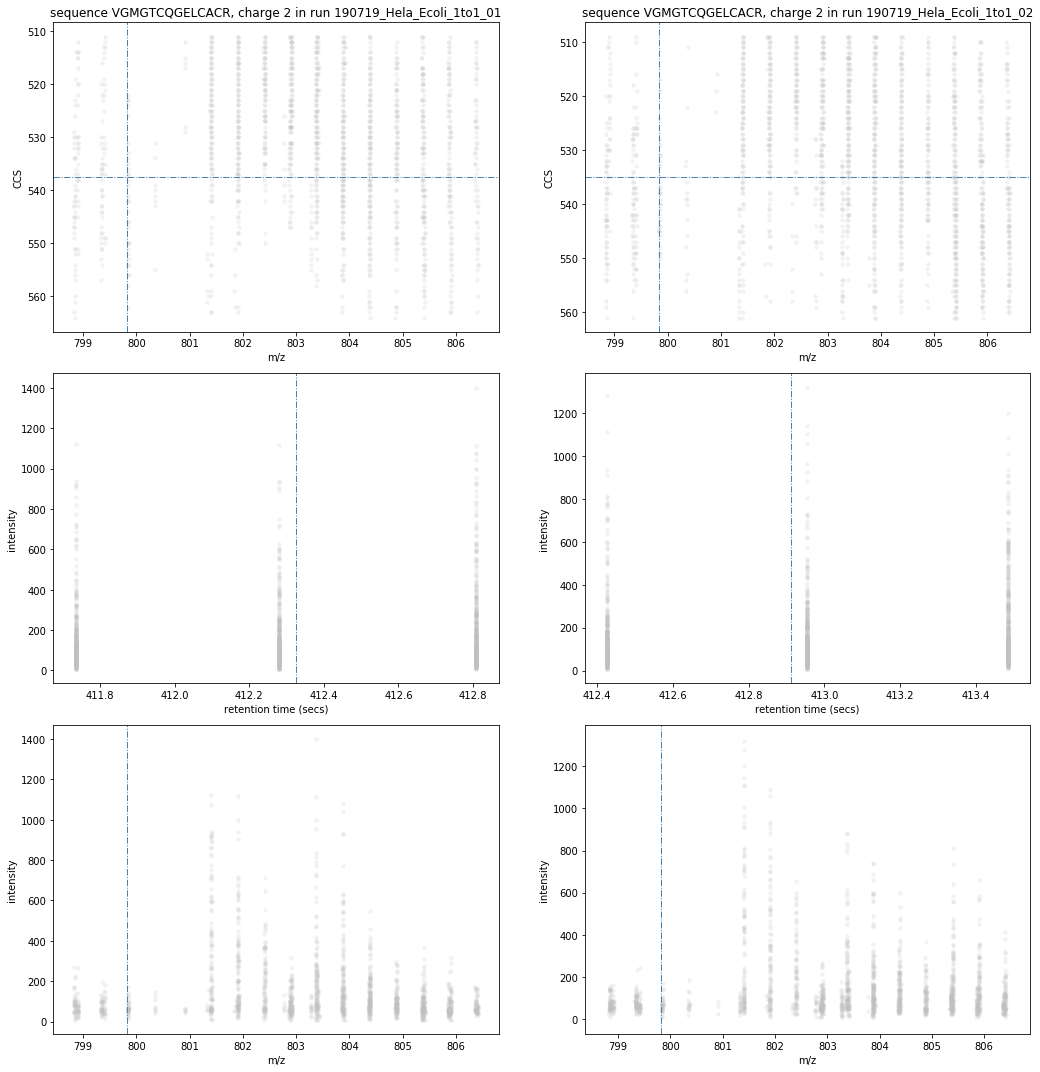

In [38]:
f, axarr = plt.subplots(nrows=3, ncols=2)

f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

########
# run A - mz vs scan
########
ax = axarr[0,0]  # row, column
ax.set_title('sequence {}, charge {} in run {}'.format(selected_sequence, selected_sequence_charge, run_name_A))

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_A['mono_mz'], color='steelblue', lw=1.0, ls='-.')
ax.axhline(feature_coordinates_A['scan_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run A - RT vs intensity
########
ax = axarr[1,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.retention_time_secs, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_A['rt_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run A - mz vs intensity
########
ax = axarr[2,0]

# plot the background points in the feature region
ax.scatter(frames_subset_A_df.mz, frames_subset_A_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_A['mono_mz'], color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('intensity')






########
# run B - mz vs scan
########
ax = axarr[0,1]
ax.set_title('sequence {}, charge {} in run {}'.format(selected_sequence, selected_sequence_charge, run_name_B))

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.scan, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_B['mono_mz'], color='steelblue', lw=1.0, ls='-.')
ax.axhline(feature_coordinates_B['scan_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('CCS')
ax.invert_yaxis()

########
# run B - RT vs intensity
########
ax = axarr[1,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.retention_time_secs, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_B['rt_apex'], color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

########
# run B - mz vs intensity
########
ax = axarr[2,1]

# plot the background points in the feature region
ax.scatter(frames_subset_B_df.mz, frames_subset_B_df.intensity, marker='o', color='silver', lw=0, s=20, alpha=0.2)

# draw the monoisotopic apex
ax.axvline(feature_coordinates_B['mono_mz'], color='steelblue', lw=1.0, ls='-.')

ax.set_xlabel('m/z')
ax.set_ylabel('intensity')

plt.tight_layout()
plt.show()